# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.028953,False,1.183704
1,-2.671505,False,-3.381404
2,-1.807897,False,-3.114475
3,0.589487,True,7.262895
4,1.153648,True,5.152697
...,...,...,...
995,1.822792,True,8.615791
996,-0.130931,True,3.533773
997,-2.798855,False,-4.505421
998,-1.495691,False,-2.905536


<AxesSubplot:xlabel='v0'>

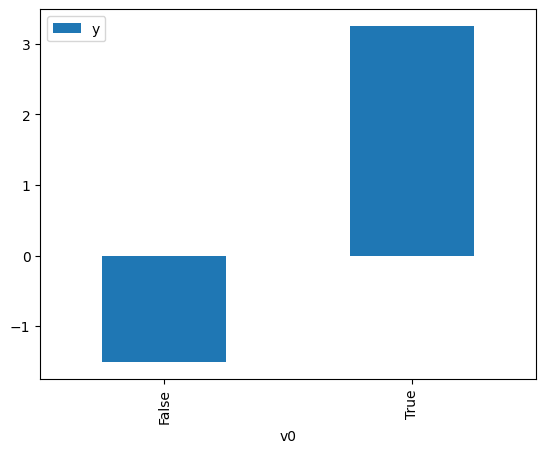

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

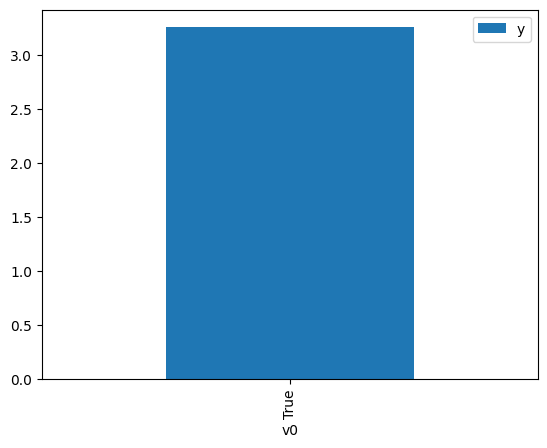

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.037775,False,-5.209848,0.776978,1.287038
1,-1.955067,False,-3.523390,0.767364,1.303162
2,-0.725699,False,0.747073,0.594139,1.683107
3,-0.582994,False,-0.739827,0.571213,1.750660
4,-1.202951,False,-1.190988,0.667407,1.498337
...,...,...,...,...,...
995,-1.760318,False,-4.400352,0.743606,1.344799
996,-0.924579,False,-0.429571,0.625398,1.598981
997,-1.084845,False,-3.405073,0.649862,1.538788
998,-0.099031,False,1.167137,0.491749,2.033558


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.710639,True,2.005712,0.262703,3.806577
1,-0.399367,True,4.132107,0.458729,2.179935
2,0.177754,True,6.923106,0.553769,1.805807
3,-2.497404,True,1.638349,0.174816,5.720292
4,-0.941595,True,4.835776,0.371971,2.688382
...,...,...,...,...,...
995,-0.958727,True,2.590399,0.369330,2.707605
996,-0.352063,True,2.577401,0.466500,2.143622
997,-0.312568,True,4.017700,0.473001,2.114160
998,-1.059234,True,1.612482,0.353999,2.824869


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              5866.
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                        0.00
Time:                        17:39:34   Log-Likelihood:                         -1399.5
No. Observations:                1000   AIC:                                      2803.
Df Residuals:                     998   BIC:                                      2813.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6782      0.023     71.821      0.000       1.632       1.724
x2             4.9492      0.052     96.085      0.000       4.848       5.050
==============================================================================
Omnibus:                        2.915   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.794
Skew:                          -0.101   Prob(JB):                        0.247
Kurtosis:                       3.161   Cond. No.                         2.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""